# Isopycnal surface depths and mixed layer depths from the Oceanic Pathways model fields

In [30]:
import calendar
from typing import TYPE_CHECKING, cast

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from scipy.interpolate import griddata
from tqdm import tqdm

from utils import get_mixed_layer_depth_path, open_monthly_mean_isopycnal_depth

if TYPE_CHECKING:
    from cartopy.mpl.geoaxes import GeoAxes

## Monthly mean 25.8 sigma isopycnal depths

In [ ]:
def grid_monthly_mean_isopycnal_depth(ds: xr.Dataset) -> xr.Dataset:
    """Regrid the monthly mean isopycnal depth dataset to a regular grid.

    Args:
        ds (xr.Dataset): Input dataset with isopycnal depth on original grid.

    Returns:
        xr.Dataset: Gridded dataset with isopycnal depth on regular grid.

    """
    # Define the target grid
    lon_grid = np.arange(ds["lon_rho"].min(), ds["lon_rho"].max(), 0.05)
    lat_grid = np.arange(ds["lat_rho"].min(), ds["lat_rho"].max(), 0.05)

    lon_mgrid, lat_mgrid = np.meshgrid(lon_grid, lat_grid)

    lon_rho = ds["lon_rho"].to_numpy().flatten()
    lat_rho = ds["lat_rho"].to_numpy().flatten()

    grid_isopycnal_depth = np.empty((ds["depth"].shape[0], lon_mgrid.shape[0], lat_mgrid.shape[1])) * np.nan
    # Interpolate the isopycnal depth data
    for i in tqdm(range(ds["depth"].shape[0])):
        isopycnal_depth = ds["depth"][i, :, :].to_numpy().flatten()

        grid_isopycnal_depth[i, :, :] = griddata(
            (lon_rho, lat_rho),
            isopycnal_depth,
            (lon_mgrid, lat_mgrid),
            method="linear",
            fill_value=np.nan,
        )

    # Create a new dataset with the target grid
    ds_gridded = xr.Dataset(
        {
            "depth": (["month", "lat", "lon"], grid_isopycnal_depth),
        },
        coords={
            "month": ds["month"],
            "lon": lon_grid,
            "lat": lat_grid,
        },
    )

    return ds_gridded

In [47]:
PARENT_PATH = "D:/avg"
TARGET_SIGMA_0 = 25.8

monthly_mean_25_8 = open_monthly_mean_isopycnal_depth(PARENT_PATH, TARGET_SIGMA_0)
monthly_mean_25_8

<xarray.Dataset> Size: 118MB
Dimensions:  (month: 12, eta_rho: 962, xi_rho: 962)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    lat_rho  (eta_rho, xi_rho) float64 7MB dask.array<chunksize=(962, 962), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float64 7MB dask.array<chunksize=(962, 962), meta=np.ndarray>
    x_rho    (eta_rho, xi_rho) float64 7MB dask.array<chunksize=(962, 962), meta=np.ndarray>
    y_rho    (eta_rho, xi_rho) float64 7MB dask.array<chunksize=(962, 962), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    depth    (month, eta_rho, xi_rho) float64 89MB dask.array<chunksize=(1, 962, 962), meta=np.ndarray>

In [48]:
monthly_mean_25_8 = grid_monthly_mean_isopycnal_depth(monthly_mean_25_8)

100%|██████████| 12/12 [08:40<00:00, 43.36s/it]

(12, 403, 534)


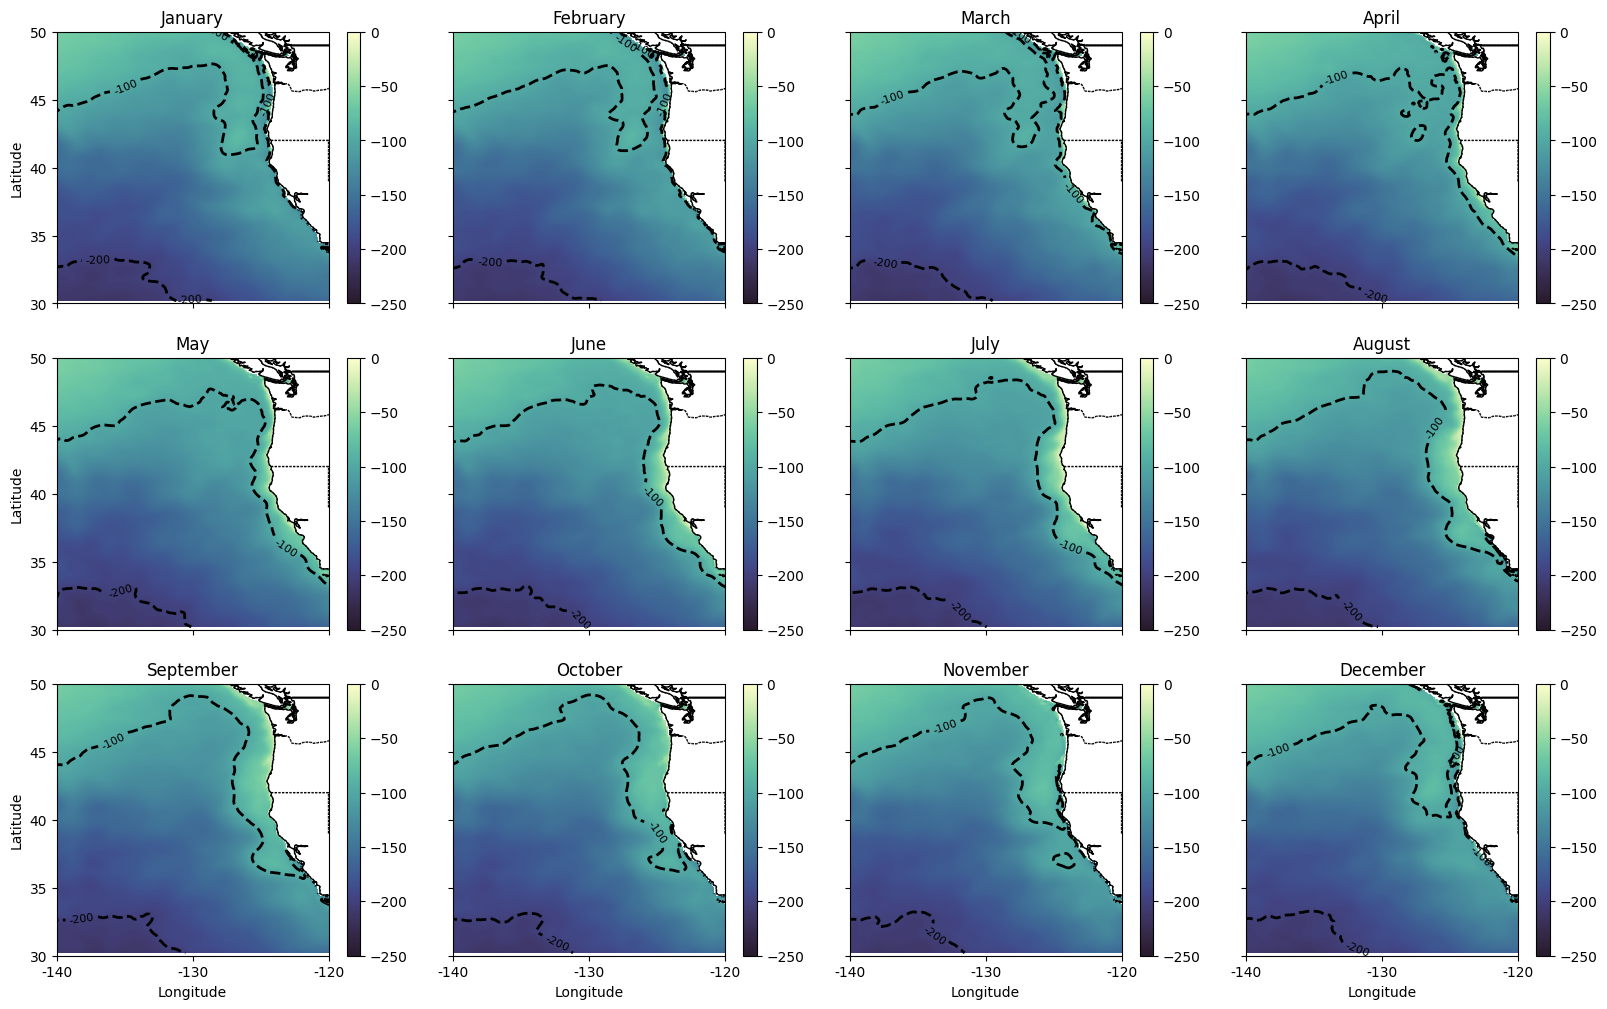

In [ ]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12), subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# For plot axis limits
lon_min, lon_max = -140, -120
lat_min, lat_max = 30, 50

for month in range(1, 13):
    row = (month - 1) // 4
    col = (month - 1) % 4
    # Need to explicitly cast to GeoAxes for type checking,
    # since plt.subplots doesn't return different types based on subplot_kw
    ax = cast("GeoAxes", axs[row, col])
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        monthly_mean_25_8["lon"],
        monthly_mean_25_8["lat"],
        monthly_mean_25_8["depth"].sel(month=month),
        shading="auto",
        vmin=-250,
        vmax=0,
        cmap=cmo.deep_r,  # pyright: ignore[reportAttributeAccessIssue]
        transform=ccrs.PlateCarree(),
    )
    fig.colorbar(pcm, ax=ax, orientation="vertical")

    cs = ax.contour(
        monthly_mean_25_8["lon"],
        monthly_mean_25_8["lat"],
        monthly_mean_25_8["depth"].sel(month=month),
        levels=[-200, -100, 0],
        colors="k",
        linewidths=2,
        transform=ccrs.PlateCarree(),
    )

    plt.clabel(cs, inline=True, fontsize=8, fmt="%d")

    ax.set_title(str(calendar.month_name[month]))
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if row == nrows - 1:
        ax.set_xlabel("Longitude")
        lon_formatter = LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticklabels(np.arange(lon_min, lon_max + 1, 10))
    if col == 0:
        ax.set_ylabel("Latitude")
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticklabels(np.arange(lat_min, lat_max + 1, 5))

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=":")
plt.savefig("../misc/oceanic_pathway_isopycnal_depth_25.8.png", dpi=600, bbox_inches="tight")

## Monthly means mixed layer depth

In [ ]:
mld = xr.open_zarr(get_mixed_layer_depth_path("D:/avg", delta_sigma=0.1))["depth"]
mld_monthly_mean = mld.groupby("time.month").mean("time")
mld_monthly_mean.compute()
mld_monthly_mean = grid_monthly_mean_isopycnal_depth(
    mld_monthly_mean.to_dataset().transpose("month", "eta_rho", "xi_rho"),
)

<xarray.DataArray 'depth' (eta_rho: 962, xi_rho: 962, month: 12)> Size: 89MB
array([[[-115.77962533, -127.3875093 , -121.4289735 , ...,
          -51.81384579,  -69.64204708,  -93.13117392],
        [-115.49350832, -126.60177909, -121.30063933, ...,
          -51.79618268,  -69.52925846,  -92.88063068],
        [-115.74745892, -127.44759666, -121.32961506, ...,
          -51.90920479,  -69.66895332,  -93.22292237],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[-116.09457672, -128.17295777, -121.58400226, ...,
          -51.83112182,  -69.75278123,  -93.38197798],
        [-114.11364072, -125.40765941, -119.6800914 , ...,
          -51.15098037,  -68.8315848 ,  -92.28535978],
        [-114.05620659, -125.48789249, -119.45681012, ...,
          -51.05765806,  -68.77869888,  -92.25711417],
...
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[ -45.8821657 ,  -46.78142569,  -47.77674686, ...,
          -20.99015696,  -31.45692852,  -41.87770475],
        [ -45.24118528,  -46.16887355,  -47.10176883, ...,
          -20.76238441,  -31.09069789,  -41.2518542 ],
        [ -44.60356599,  -45.52834751,  -46.3762585 , ...,
          -20.66533535,  -30.75762189,  -40.66256048],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]],
      shape=(962, 962, 12))
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    lat_rho  (eta_rho, xi_rho) float64 7MB 30.15 30.15 30.15 ... 50.29 50.29
    lon_rho  (eta_rho, xi_rho) float64 7MB -142.1 -142.0 ... -115.4 -115.4
    x_rho    (eta_rho, xi_rho) float64 7MB 2.013e+06 2.015e+06 ... 3.383e+06
    y_rho    (eta_rho, xi_rho) float64 7MB 4.462e+06 4.462e+06 ... 6.7e+06
Dimensions without coordinates: eta_rho, xi_rho

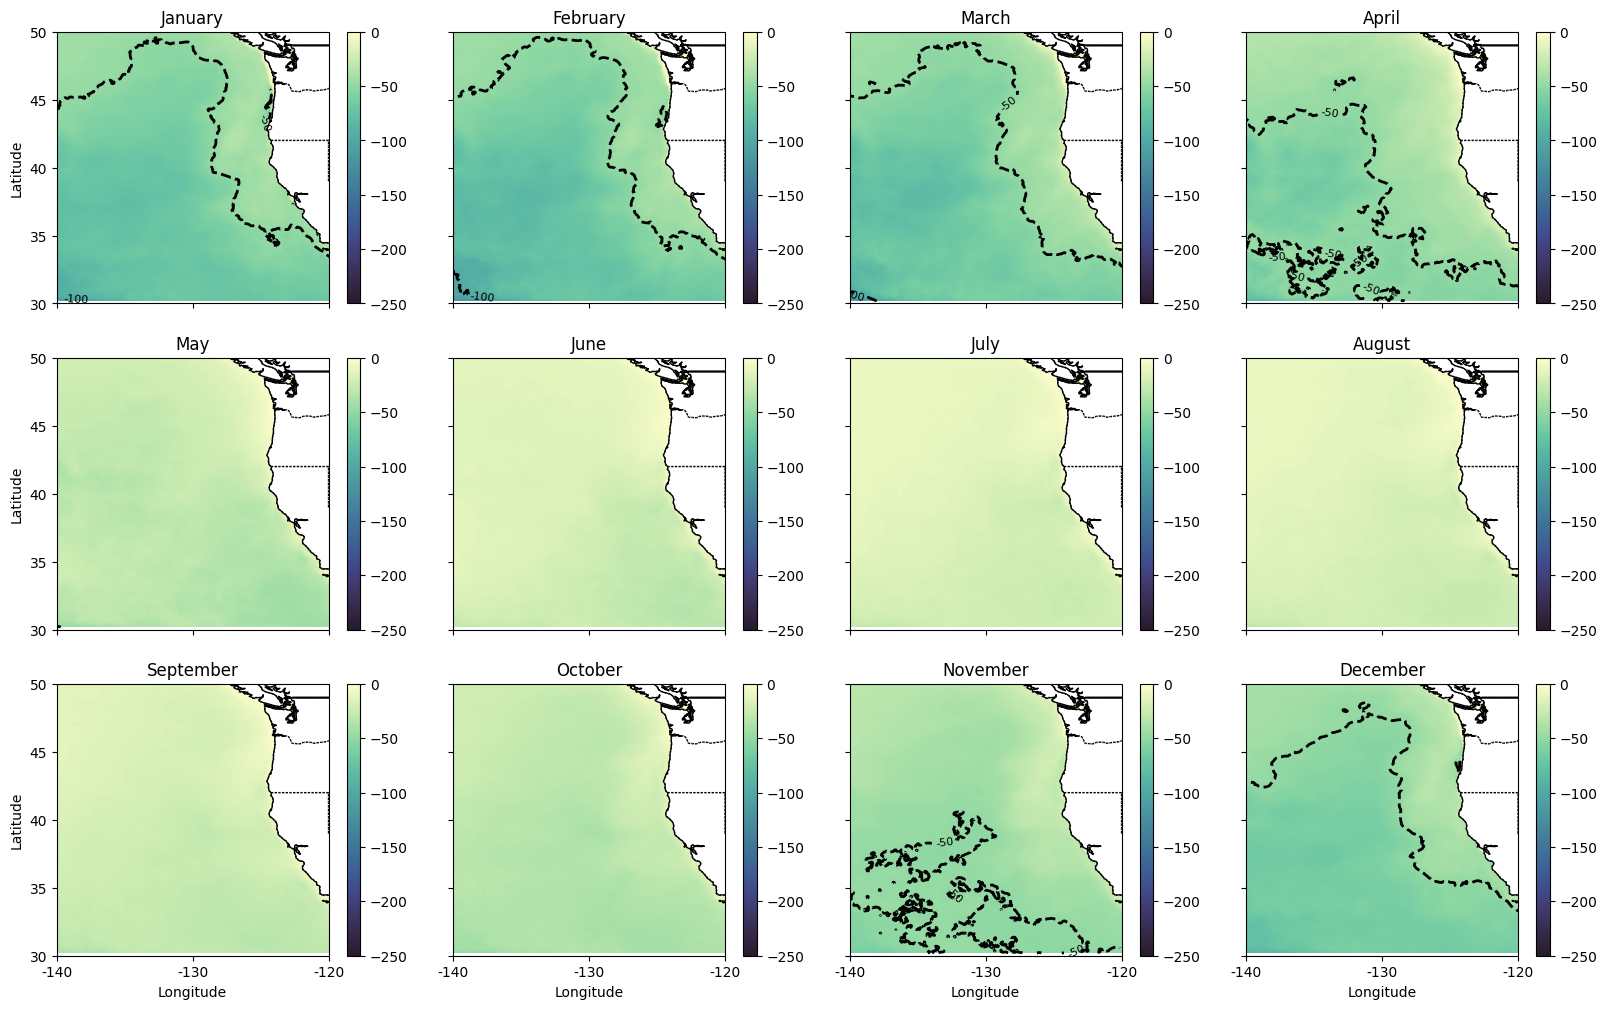

In [29]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12), subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# For plot axis limits
lon_min, lon_max = -140, -120
lat_min, lat_max = 30, 50

for month in range(1, 13):
    row = (month - 1) // 4
    col = (month - 1) % 4
    # Need to explicitly cast to GeoAxes for type checking,
    # since plt.subplots doesn't return different types based on subplot_kw
    ax = cast("GeoAxes", axs[row, col])
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        mld_monthly_mean["lon"],
        mld_monthly_mean["lat"],
        mld_monthly_mean["depth"].sel(month=month),
        shading="auto",
        vmin=-250,
        vmax=0,
        cmap=cmo.deep_r,  # pyright: ignore[reportAttributeAccessIssue]
        transform=ccrs.PlateCarree(),
    )
    fig.colorbar(pcm, ax=ax, orientation="vertical")

    cs = ax.contour(
        mld_monthly_mean["lon"],
        mld_monthly_mean["lat"],
        mld_monthly_mean["depth"].sel(month=month),
        levels=[-100, -50, 0],
        colors="k",
        linewidths=2,
        transform=ccrs.PlateCarree(),
    )

    plt.clabel(cs, inline=True, fontsize=8, fmt="%d")

    ax.set_title(str(calendar.month_name[month]))
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if row == nrows - 1:
        ax.set_xlabel("Longitude")
        lon_formatter = LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticklabels(np.arange(lon_min, lon_max + 1, 10))
    if col == 0:
        ax.set_ylabel("Latitude")
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticklabels(np.arange(lat_min, lat_max + 1, 5))

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=":")

plt.savefig("../misc/oceanic_pathway_mixed_layer_depth.png", dpi=600, bbox_inches="tight")

## Difference between 25.8 sigma isopycnal surface depth and mixed layer depth

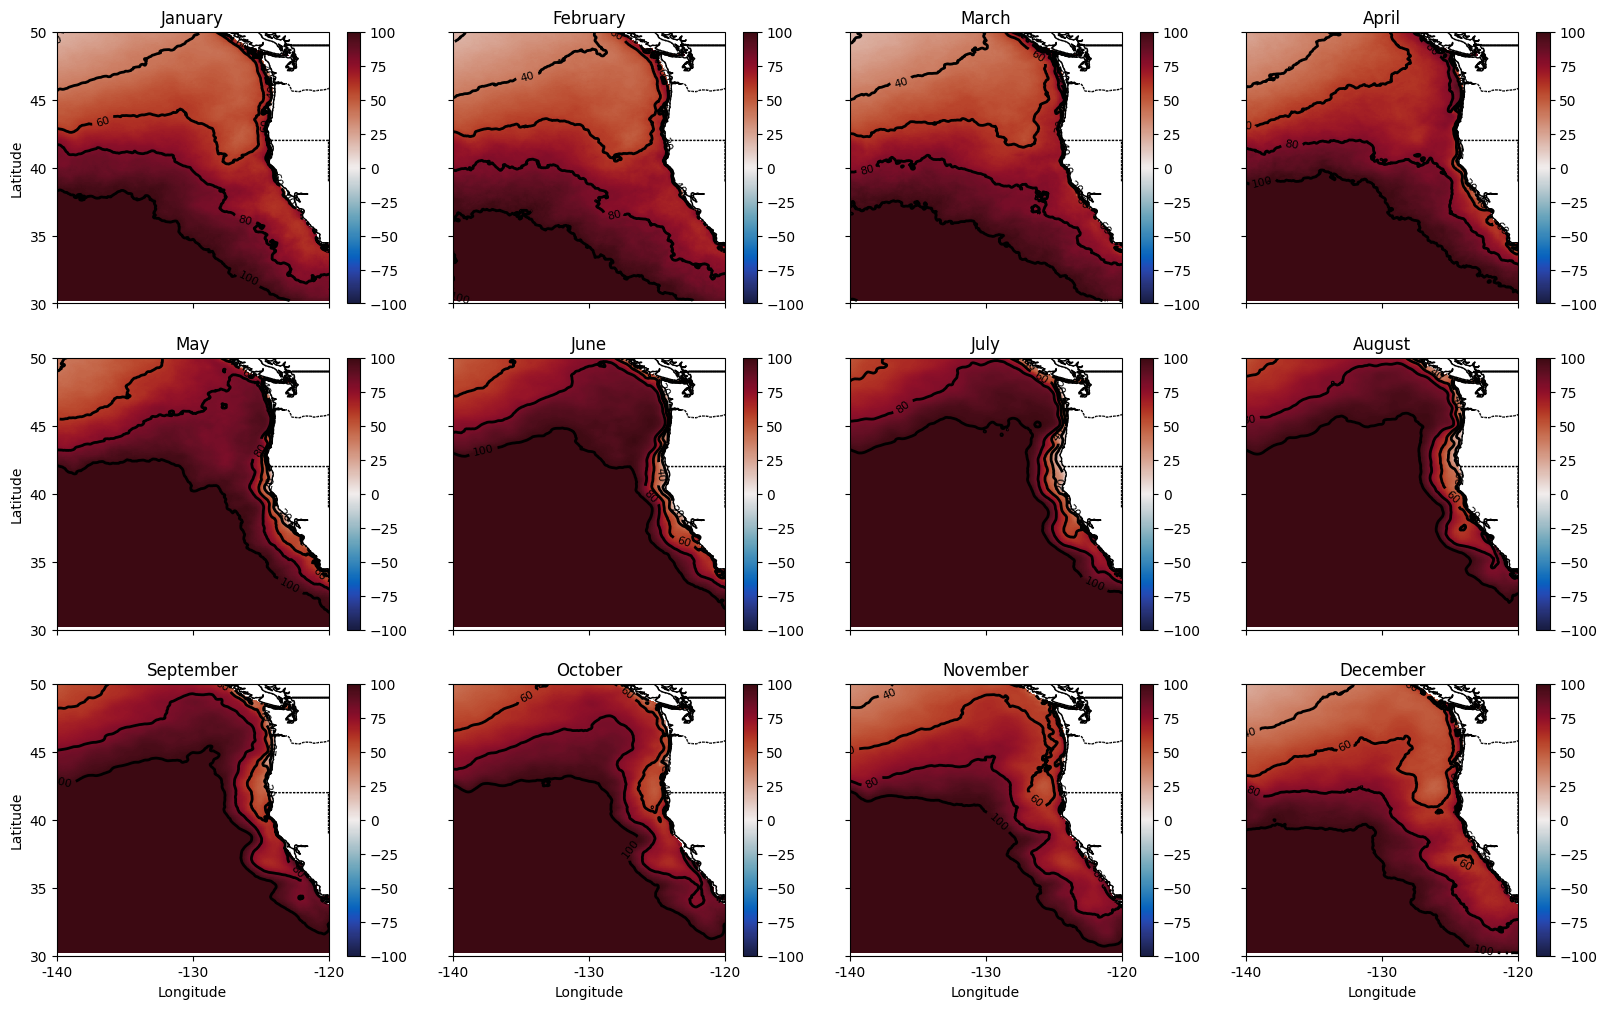

In [54]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12), subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# For plot axis limits
lon_min, lon_max = -140, -120
lat_min, lat_max = 30, 50

for month in range(1, 13):
    row = (month - 1) // 4
    col = (month - 1) % 4
    # Need to explicitly cast to GeoAxes for type checking,
    # since plt.subplots doesn't return different types based on subplot_kw
    ax = cast("GeoAxes", axs[row, col])
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        mld_monthly_mean["lon"],
        mld_monthly_mean["lat"],
        mld_monthly_mean["depth"].sel(month=month) - monthly_mean_25_8["depth"].sel(month=month),
        shading="auto",
        vmin=-100,
        vmax=100,
        cmap=cmo.balance,  # pyright: ignore[reportAttributeAccessIssue]
        transform=ccrs.PlateCarree(),
    )
    fig.colorbar(pcm, ax=ax, orientation="vertical")

    cs = ax.contour(
        mld_monthly_mean["lon"],
        mld_monthly_mean["lat"],
        mld_monthly_mean["depth"].sel(month=month) - monthly_mean_25_8["depth"].sel(month=month),
        levels=np.arange(-100, 101, 20),
        colors="k",
        linewidths=2,
        transform=ccrs.PlateCarree(),
    )

    plt.clabel(cs, inline=True, fontsize=8, fmt="%d")

    ax.set_title(str(calendar.month_name[month]))
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if row == nrows - 1:
        ax.set_xlabel("Longitude")
        lon_formatter = LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticklabels(np.arange(lon_min, lon_max + 1, 10))
    if col == 0:
        ax.set_ylabel("Latitude")
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticklabels(np.arange(lat_min, lat_max + 1, 5))

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=":")

plt.savefig("../misc/oceanic_pathway_25.8_isopycnal_mld_diff.png", dpi=600, bbox_inches="tight")